# Laboratory of Computational Physics mod. B
# Title????
Authors:
Valeria Fioroni, 
Matteo Guida,
Philipp Zehetner

In [1]:
import pandas as pd
import os
from root_pandas import read_root
import tensorflow as tf
import seaborn as sns
import numpy as np
import glob

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA

from scipy import interp

import matplotlib.pyplot as plt

from IPython.display import display

from random import seed
from random import randint

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

Welcome to JupyROOT 6.16/00


## Read Data

In [2]:
def memory(df):
    print(str((round(df.memory_usage(deep=True).sum() / 1024 ** 2, 2))),"Mb")
    
path = '/home/utente/Scrivania/Progetto LCP-B/DataBelle2/'
SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
CFiles = glob.glob(os.path.join(path, 'Background/Continuum/*.root'))
PFiles = glob.glob(os.path.join(path, 'Background/Peaking/*.root'))

Signal = pd.concat((read_root(f, 'B0') for f in SFiles))
Continuum_bkg = pd.concat((read_root(f, 'B0') for f in CFiles))
Peaking_bkg = pd.concat((read_root(f, 'B0') for f in PFiles))    

#Signal: require B0_isSignal == True
Signal=Signal[Signal['B0_isSignal']== True]
#reset row indexing
Signal.reset_index(drop=True, inplace=True)
print(Signal.shape)

#Continuum: require B0_isContinuumEvent == True
Continuum_bkg=Continuum_bkg[Continuum_bkg['B0_isContinuumEvent']== True]
#reset row indexing
Continuum_bkg.reset_index(drop=True, inplace=True)
print(Continuum_bkg.shape)

#Peaking: require B0_isNotContinuumEvent == True
Peaking_bkg=Peaking_bkg[Peaking_bkg['B0_isNotContinuumEvent']== True]
#reset row indexing
Peaking_bkg.reset_index(drop=True, inplace=True)
print(Peaking_bkg.shape)


memory(Signal)
memory(Continuum_bkg)
memory(Peaking_bkg)

/home/utente/.local/lib/python3.6/site-packages/root_pandas/readwrite.py:320: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  df = df.reindex_axis(columns, axis=1, copy=False)


(20491, 391)
(1847, 391)
(208, 391)
106.7 Mb
9.62 Mb
1.08 Mb


## Useful lists of variables

In [3]:
General = ['exp_no', 'run_no', 'evt_no', 'nCands', 'iCand']
Masses = ['B0_M', 'B0_ErrM', 'B0_SigM', 'B0_K_S0_M', 'B0_K_S0_ErrM', 'B0_K_S0_SigM', 'B0_etap_M', 'B0_etap_ErrM', 
          'B0_etap_SigM', 'B0_etap_eta_M', 'B0_etap_eta_ErrM', 'B0_etap_eta_SigM']
Kinetics = ['B0_P', 'B0_P4', 'B0_deltae', 'B0_mbc', 'B0_etap_P', 'B0_etap_P4', 
            'B0_etap_eta_P', 'B0_etap_eta_P4', 'B0_etap_eta_gamma0_P', 'B0_etap_eta_gamma0_P4',
            'B0_etap_eta_gamma1_P', 'B0_etap_eta_gamma1_P4', 'B0_etap_pi0_P', 'B0_etap_pi0_P4',
            'B0_etap_pi1_P', 'B0_etap_pi1_P4', 'B0_K_S0_P', 'B0_K_S0_P4']
Kinetics_CM =[]
Kinetics_comp = ['B0_P', 'B0_P40', 'B0_P41', 'B0_P42', 'B0_P43', 'B0_deltae', 'B0_mbc',
                 'B0_etap_P', 'B0_etap_P40', 'B0_etap_P41', 'B0_etap_P42','B0_etap_P43','B0_etap_eta_P',
                 'B0_etap_eta_P40', 'B0_etap_eta_P41', 'B0_etap_eta_P42', 'B0_etap_eta_P43',
                 'B0_etap_eta_gamma0_P', 'B0_etap_eta_gamma0_P40', 'B0_etap_eta_gamma0_P41', 
                 'B0_etap_eta_gamma0_P42', 'B0_etap_eta_gamma0_P43', 'B0_etap_eta_gamma1_P', 'B0_etap_eta_gamma1_P40',
                 'B0_etap_eta_gamma1_P41', 'B0_etap_eta_gamma1_P42', 'B0_etap_eta_gamma1_P43', 'B0_etap_pi0_P',
                 'B0_etap_pi0_P40', 'B0_etap_pi0_P41', 'B0_etap_pi0_P42', 'B0_etap_pi0_P43', 'B0_etap_pi1_P',
                 'B0_etap_pi1_P40', 'B0_etap_pi1_P41', 'B0_etap_pi1_P42', 'B0_etap_pi1_P43', 'B0_K_S0_P',
                 'B0_K_S0_P40', 'B0_K_S0_P41', 'B0_K_S0_P42', 'B0_K_S0_P43']
FourMomenta = ['B0_P4', 'B0_etap_P4', 'B0_etap_eta_P4', 'B0_etap_eta_gamma0_P4', 'B0_etap_eta_gamma1_P4', 'B0_etap_pi0_P4', 'B0_etap_pi1_P4', 'B0_K_S0_P4']
DecayAngles = ['B0_decayAngle__bo0__bc', 'B0_decayAngle__bo1__bc', 'B0_etap_decayAngle__bo0__bc',
               'B0_etap_decayAngle__bo1__bc', 'B0_etap_decayAngle__bo2__bc']
Positions = ['B0_X', 'B0_ErrX', 'B0_Y', 'B0_ErrY', 'B0_Z', 'B0_ErrZ', 'B0_Rho',  
             'B0_etap_X', 'B0_etap_ErrX', 'B0_etap_Y', 'B0_etap_ErrY', 
             'B0_etap_Z', 'B0_etap_ErrZ', 'B0_etap_Rho',
             'B0_etap_eta_X', 'B0_etap_eta_ErrX', 'B0_etap_eta_Y',
             'B0_etap_eta_ErrY', 'B0_etap_eta_Z', 'B0_etap_eta_ErrZ', 'B0_etap_eta_Rho',
             'B0_etap_pi0_X', 'B0_etap_pi0_ErrX', 'B0_etap_pi0_Y', 'B0_etap_pi0_ErrY', 
             'B0_etap_pi0_Z', 'B0_etap_pi0_ErrZ', 'B0_etap_pi0_Rho', 
             'B0_etap_pi1_X', 'B0_etap_pi1_ErrX', 'B0_etap_pi1_Y', 'B0_etap_pi1_ErrY', 
             'B0_etap_pi1_Z', 'B0_etap_pi1_ErrZ', 'B0_etap_pi1_Rho', 
             'B0_K_S0_X', 'B0_K_S0_ErrX', 'B0_K_S0_Y', 'B0_K_S0_ErrY', 'B0_K_S0_Z',
             'B0_K_S0_ErrZ', 'B0_K_S0_Rho', 
             'B0_cosAngleBetweenMomentumAndVertexVector', 'B0_distance', 'B0_significanceOfDistance',
             'B0_dr', 'B0_etap_pi0_dr', 'B0_etap_pi1_dr', 'B0_K_S0_dr']
Vertex = ['B0_VtxPvalue', 'B0_VtxProd', 'B0_VtxProdCov', 'B0_etap_VtxPvalue', 'B0_etap_VtxProd', 'B0_etap_VtxProdCov',
          'B0_etap_eta_VtxPvalue', 'B0_etap_eta_VtxProd', 'B0_etap_VtxProdCov', 
          'B0_etap_pi0_VtxPvalue', 'B0_etap_pi0_VtxProd', 'B0_etap_pi0_VtxProdCov', 
          'B0_etap_pi1_VtxPvalue', 'B0_etap_pi1_VtxProd', 'B0_etap_pi1_VtxProdCov', 
          'B0_K_S0_VtxPvalue', 'B0_K_S0_VtxProd', 'B0_K_S0_VtxProdCov']

Vertex_train = ['B0_VtxPvalue', 'B0_etap_VtxPvalue','B0_etap_eta_VtxPvalue', 'B0_etap_pi0_VtxPvalue', 
                'B0_etap_pi1_VtxPvalue', 'B0_K_S0_VtxPvalue']
Continuum_Supression = ['B0_CSMVA', 'B0_TrCSMVA']


Important_variables= Masses + Kinetics + DecayAngles + Positions + Vertex_train + Continuum_Supression
print(Important_variables)


['B0_M', 'B0_ErrM', 'B0_SigM', 'B0_K_S0_M', 'B0_K_S0_ErrM', 'B0_K_S0_SigM', 'B0_etap_M', 'B0_etap_ErrM', 'B0_etap_SigM', 'B0_etap_eta_M', 'B0_etap_eta_ErrM', 'B0_etap_eta_SigM', 'B0_P', 'B0_P4', 'B0_deltae', 'B0_mbc', 'B0_etap_P', 'B0_etap_P4', 'B0_etap_eta_P', 'B0_etap_eta_P4', 'B0_etap_eta_gamma0_P', 'B0_etap_eta_gamma0_P4', 'B0_etap_eta_gamma1_P', 'B0_etap_eta_gamma1_P4', 'B0_etap_pi0_P', 'B0_etap_pi0_P4', 'B0_etap_pi1_P', 'B0_etap_pi1_P4', 'B0_K_S0_P', 'B0_K_S0_P4', 'B0_decayAngle__bo0__bc', 'B0_decayAngle__bo1__bc', 'B0_etap_decayAngle__bo0__bc', 'B0_etap_decayAngle__bo1__bc', 'B0_etap_decayAngle__bo2__bc', 'B0_X', 'B0_ErrX', 'B0_Y', 'B0_ErrY', 'B0_Z', 'B0_ErrZ', 'B0_Rho', 'B0_etap_X', 'B0_etap_ErrX', 'B0_etap_Y', 'B0_etap_ErrY', 'B0_etap_Z', 'B0_etap_ErrZ', 'B0_etap_Rho', 'B0_etap_eta_X', 'B0_etap_eta_ErrX', 'B0_etap_eta_Y', 'B0_etap_eta_ErrY', 'B0_etap_eta_Z', 'B0_etap_eta_ErrZ', 'B0_etap_eta_Rho', 'B0_etap_pi0_X', 'B0_etap_pi0_ErrX', 'B0_etap_pi0_Y', 'B0_etap_pi0_ErrY', 'B0_eta

## Preselection

In [4]:
#Masses from PDG
M_B0 = [5.27955, 0.00026]
M_K0 = [0.497611, 0.000013]
M_etap = [0.95778, 0.00006]
M_eta = [0.547862, 0.000017]

#Require the B0 mass to be within 5 sigma from PDG value
Signal = Signal[abs(Signal['B0_M'] - M_B0[0]) < 5 * Signal['B0_ErrM']]
print(Signal.shape)

Continuum_bkg = Continuum_bkg[abs(Continuum_bkg['B0_M'] - M_B0[0]) < 5 * Continuum_bkg['B0_ErrM']]
print(Continuum_bkg.shape)

Peaking_bkg = Peaking_bkg[abs(Peaking_bkg['B0_M'] - M_B0[0]) < 5 * Peaking_bkg['B0_ErrM']]
print(Peaking_bkg.shape)

#Signal: In case of more than 1 candidate per event select the first one occuring
Mask_duplicated = Signal.duplicated(subset='evt_no', keep='first')
Mask_duplicated=np.logical_not(Mask_duplicated)
Signal=Signal[Mask_duplicated]
Signal.reset_index(drop=True, inplace=True)

print(Signal.shape)
print(Signal['evt_no'].nunique())

(19938, 391)
(908, 391)
(119, 391)
(19825, 391)
19825


In [5]:
#Select variables useful for the Classification task
Signal_sel = Signal[Important_variables]
del(Signal)

Continuum_bkg_sel= Continuum_bkg[Important_variables]
del(Continuum_bkg)

Peaking_bkg_sel= Peaking_bkg[Important_variables]
del(Peaking_bkg)

#drop 4-momenta: not really useful for classification
Signal_sel =Signal_sel.drop(FourMomenta, axis=1)
Continuum_bkg_sel=Continuum_bkg_sel.drop(FourMomenta, axis=1)
Peaking_bkg_sel= Peaking_bkg_sel.drop(FourMomenta, axis=1)

print(Continuum_bkg_sel.shape)
print(Peaking_bkg_sel.shape)
print(Signal_sel.shape)

(908, 84)
(119, 84)
(19825, 84)


In [6]:
pd.options.display.max_columns = None
display(Signal_sel)

,B0_M,B0_ErrM,B0_SigM,B0_K_S0_M,B0_K_S0_ErrM,B0_K_S0_SigM,B0_etap_M,B0_etap_ErrM,B0_etap_SigM,B0_etap_eta_M,B0_etap_eta_ErrM,B0_etap_eta_SigM,B0_P,B0_deltae,B0_mbc,B0_etap_P,B0_etap_eta_P,B0_etap_eta_gamma0_P,B0_etap_eta_gamma1_P,B0_etap_pi0_P,B0_etap_pi1_P,B0_K_S0_P,B0_decayAngle__bo0__bc,B0_decayAngle__bo1__bc,B0_etap_decayAngle__bo0__bc,B0_etap_decayAngle__bo1__bc,B0_etap_decayAngle__bo2__bc,B0_X,B0_ErrX,B0_Y,B0_ErrY,B0_Z,B0_ErrZ,B0_Rho,B0_etap_X,B0_etap_ErrX,B0_etap_Y,B0_etap_ErrY,B0_etap_Z,B0_etap_ErrZ,B0_etap_Rho,B0_etap_eta_X,B0_etap_eta_ErrX,B0_etap_eta_Y,B0_etap_eta_ErrY,B0_etap_eta_Z,B0_etap_eta_ErrZ,B0_etap_eta_Rho,B0_etap_pi0_X,B0_etap_pi0_ErrX,B0_etap_pi0_Y,B0_etap_pi0_ErrY,B0_etap_pi0_Z,B0_etap_pi0_ErrZ,B0_etap_pi0_Rho,B0_etap_pi1_X,B0_etap_pi1_ErrX,B0_etap_pi1_Y,B0_etap_pi1_ErrY,B0_etap_pi1_Z,B0_etap_pi1_ErrZ,B0_etap_pi1_Rho,B0_K_S0_X,B0_K_S0_ErrX,B0_K_S0_Y,B0_K_S0_ErrY,B0_K_S0_Z,B0_K_S0_ErrZ,B0_K_S0_Rho,B0_cosAngleBetweenMomentumAndVertexVector,B0_distance,B0_significanceOfDistance,B0_dr,B0_etap_pi0_dr,B0_etap_pi1_dr,B0_K_S0_dr,B0_VtxPvalue,B0_etap_VtxPvalue,B0_etap_eta_VtxPvalue,B0_etap_pi0_VtxPvalue,B0_etap_pi1_VtxPvalue,B0_K_S0_VtxPvalue,B0_CSMVA,B0_TrCSMVA
0,5.299881,0.010961,1.856670,0.500407,0.004492,0.621686,0.956255,0.002487,-0.565081,0.541614,0.012183,-0.512100,1.515685,0.017005,5.282853,2.692191,1.319945,1.065144,0.352762,1.050644,0.347592,2.607270,0.049420,-0.049420,-0.757356,0.651600,-0.466872,0.002766,0.000773,2.577107e-09,0.000004,0.017479,0.003074,0.002766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000584,0.003583,1.117744e-04,0.000688,0.018153,0.003934,0.000594,0.011486,0.004220,0.001752,0.000686,0.015565,0.004900,0.011619,1.153542,0.080861,-8.957367,0.634263,1.140494,0.146331,9.031339,0.985042,0.017697,5.694281,0.002766,0.000594,0.011619,9.031339,4.772260e-01,5.849394e-01,6.090627e-01,0.525669,0.269301,6.020966e-01,0.929897,2.585103
1,5.288764,0.034654,0.266445,0.496696,0.004302,-0.213392,0.959869,0.002066,1.069145,0.576153,0.025517,1.109071,1.523578,0.004737,5.284020,2.206780,1.247472,1.288894,0.088904,0.749844,0.245065,3.058553,-0.565273,0.565273,-0.169775,0.686004,-0.661083,0.010193,0.000913,-1.812787e-08,0.000004,0.077936,0.004304,0.010193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083896,0.051267,4.292516e-02,0.026523,0.048760,0.012323,0.094240,-0.012954,0.030980,-0.000715,0.001567,0.036367,0.019842,0.012973,0.832546,0.007392,-2.089091,0.017365,1.656585,0.014426,2.248873,0.986146,0.078599,18.054523,0.010193,0.094240,0.012973,2.248873,3.521611e-37,2.498883e-01,2.604293e-01,0.420446,0.288093,6.286056e-17,0.900429,2.202004
2,5.303726,0.024997,0.967938,0.501817,0.004086,1.028760,0.962386,0.005514,0.857073,0.556313,0.010071,0.840091,1.582277,0.019134,5.284574,3.335327,1.581271,0.914325,0.780776,0.896522,0.910280,2.002664,0.841013,-0.841013,-0.643026,0.867422,0.274933,0.001825,0.000986,-1.443796e-09,0.000004,0.007036,0.005194,0.001825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018905,0.004650,8.092406e-03,0.001910,-0.114493,0.013554,0.020564,0.005080,0.004511,0.002913,0.002563,0.028923,0.007488,0.005856,-0.707098,0.071786,2.175335,0.226304,-1.689222,0.220667,2.287372,0.995504,0.007269,1.392152,0.001825,0.020564,0.005856,2.287372,1.420309e-33,3.888407e-01,4.042452e-01,0.000721,0.085137,2.013756e-01,0.955028,3.055712
3,5.300632,0.029411,0.717458,0.513165,0.011597,1.340991,0.956870,0.004230,-0.186780,0.568429,0.017586,1.170032,1.465257,0.021604,5.278984,2.193218,1.477087,1.417994,0.185015,0.414973,0.349285,3.063621,-0.599589,0.599589,0.375516,0.515125,-0.485840,0.001472,0.000970,4.333421e-10,0.000004,0.011124,0.004767,0.001472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.005631,0.004128,-1.238059e-03,0.000889,0.014520,0.004913,0.005765,-0.018678,0.014269,0.002928,0.002351,-0.013297,0.015057,0.018906,1.771471,0.121022,-6.894200,0.501745,11.916587,0.638016,7.118153,0.974788,0.011221,2.326848,0.001472,0.005765,0.018906,7.118153,9.887545e-02,8

## Train, Validation and Test splitting

In [7]:
# seed random number generator
n_seed=2347
seed(n_seed)

In [8]:
Signal_sel['Type'] = 2 #Signal label == 2
Peaking_bkg_sel['Type'] = 1 # Peaking background label == 1
Continuum_bkg_sel['Type'] = 0 #Continuum backgroun label == 0
'''***********************************************************************************************************
**************************************************************************************************************
I can't think of a way of doing the following with a for loop. I don't want to create a 
list with the dataframes because it would take a lot memory...if you find an efficient way of doing the
train-validation-test splitting keeping signal and different background separated let me know and change the code,
I'll try to find a way of doing it more efficiently too
****************************************************************************************************************
****************************************************************************************'''
#SIGNAL: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Signal_sel.drop('Type',axis=1)
Y = Signal_sel['Type']
Y = label_binarize(Y, classes=[0, 1, 2]) # Binarize the labels
X_train_S, X_test_val_S, Y_train_S, Y_test_val_S = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_S
Y = Y_test_val_S
X_validation_S, X_test_S, Y_validation_S, Y_test_S = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_S)
del(Y_test_val_S)

#CONTINUUM BKG: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Continuum_bkg_sel.drop('Type',axis=1)
Y = Continuum_bkg_sel['Type']
Y = label_binarize(Y, classes=[0, 1, 2]) # Binarize the labels
X_train_C, X_test_val_C, Y_train_C, Y_test_val_C = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_C
Y = Y_test_val_C
X_validation_C, X_test_C, Y_validation_C, Y_test_C = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_C)
del(Y_test_val_C)

#PEAKING BKG: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Peaking_bkg_sel.drop('Type',axis=1)
Y = Peaking_bkg_sel['Type']
Y = label_binarize(Y, classes=[0, 1, 2]) # Binarize the labels
X_train_P, X_test_val_P, Y_train_P, Y_test_val_P = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_P
Y = Y_test_val_P
X_validation_P, X_test_P, Y_validation_P, Y_test_P = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_P)
del(Y_test_val_P)

del(Signal_sel)
del(Peaking_bkg_sel)
del(Continuum_bkg_sel)

#Define Training, Validation and Test datasets
X_train=np.concatenate((X_train_S, X_train_C, X_train_P), axis=0)
X_validation=np.concatenate((X_validation_S, X_validation_C, X_validation_P), axis=0)
X_test=np.concatenate((X_test_S, X_test_C, X_test_P), axis=0)

Y_train=np.concatenate((Y_train_S, Y_train_C, Y_train_P), axis=0)
Y_validation=np.concatenate((Y_validation_S, Y_validation_C, Y_validation_P), axis=0)
Y_test=np.concatenate((Y_test_S, Y_test_C, Y_test_P), axis=0)

print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

print(X_train.nbytes/(1024 ** 2), "Mb")
print(X_validation.nbytes/(1024 ** 2), "Mb")
print(X_test.nbytes/(1024 ** 2), "Mb")
n_classes = Y_train.shape[1]


#shuffle the dataset
permutation = np.random.permutation(X_train.shape[0])
X_train = X_train[permutation]
Y_train = Y_train[permutation]

permutation = np.random.permutation(X_validation.shape[0])
X_validation = X_validation[permutation]
Y_validation = Y_validation[permutation]

permutation = np.random.permutation(X_test.shape[0])
X_test = X_test[permutation]
Y_test = Y_test[permutation]


(10425, 84)
(6255, 84)
(4172, 84)
3.3405303955078125 Mb
2.0043182373046875 Mb
1.33685302734375 Mb


## Feature scaling on the dataset
Center the points around their mean and scale them by their sample standard deviation. 
It seems that in general the algorithms of machine learning algorithms perform better after this kind of scaling.

Standardization of a dataset is a common requirement for many machine learning estimators: 
they might behave badly if the individual features do not more or less look like standard normally 
distributed data (e.g. Gaussian with 0 mean and unit variance). [More infos](https://scikit-learn.org/stable/modules/preprocessing.html)

In [9]:
ss = StandardScaler()
print(ss.fit(X_train))
# The averages and standard deviations of all the databases are saved, 
# now with transfer I modify the data (Train and Test) in practice
X_train = ss.transform(X_train)
X_validation = ss.transform(X_validation)
X_test = ss.transform(X_test)

StandardScaler(copy=True, with_mean=True, with_std=True)


# Principal Component Analysis

84


Text(0.5, 1.0, 'Explained variance VS n° components')

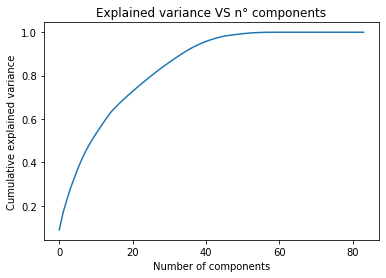

In [10]:
n_features=X_train.shape[1]
print(n_features)
pca = PCA(n_components=n_features)
pca.fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title("Explained variance VS n° components")

# Model Optimization

# ************** DRAFT **************
in "parameters" I would like to put also different possibilities for learning rate and solver at least. Maybe just 3 different learning rates and 2 different solvers, otherwise it could take too long to run

In [11]:
parameters = {'hidden_layer_sizes': [(50,100,50,), (50,100,100,50,), (50, 200, 300, 400,100)],
              'solver': ['sgd', 'adam'],
              #'learning_rate_init': [0.1, 0.01, 0.001]
              'learning_rate_init': [0.1, 0.01]
             }


mlp = MLPClassifier(max_iter=300, alpha=1e-4,
                    tol=1e-4, random_state=n_seed)

clf= GridSearchCV(mlp,param_grid=parameters,verbose=2,cv=5,return_train_score=True)

clf.fit(X_train, Y_train)

print ('RESULTS FOR NN\n')
print("Best parameters set found:")
print(clf.best_params_)

print("Score with best parameters:")
print(clf.best_score_)

print("\nAll scores on the grid:")
scores=pd.DataFrame(clf.cv_results_)
print(scores[['param_hidden_layer_sizes', 'param_solver', 'param_learning_rate_init', 'mean_test_score', 'mean_train_score']])

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] hidden_layer_sizes=(50, 100, 50), learning_rate_init=0.1, solver=sgd 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  hidden_layer_sizes=(50, 100, 50), learning_rate_init=0.1, solver=sgd, total=   6.0s
[CV] hidden_layer_sizes=(50, 100, 50), learning_rate_init=0.1, solver=sgd 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s


[CV]  hidden_layer_sizes=(50, 100, 50), learning_rate_init=0.1, solver=sgd, total=   6.4s
[CV] hidden_layer_sizes=(50, 100, 50), learning_rate_init=0.1, solver=sgd 
[CV]  hidden_layer_sizes=(50, 100, 50), learning_rate_init=0.1, solver=sgd, total=   5.4s
[CV] hidden_layer_sizes=(50, 100, 50), learning_rate_init=0.1, solver=sgd 
[CV]  hidden_layer_sizes=(50, 100, 50), learning_rate_init=0.1, solver=sgd, total=   7.1s
[CV] hidden_layer_sizes=(50, 100, 50), learning_rate_init=0.1, solver=sgd 
[CV]  hidden_layer_sizes=(50, 100, 50), learning_rate_init=0.1, solver=sgd, total=   6.5s
[CV] hidden_layer_sizes=(50, 100, 50), learning_rate_init=0.1, solver=adam 
[CV]  hidden_layer_sizes=(50, 100, 50), learning_rate_init=0.1, solver=adam, total=   3.5s
[CV] hidden_layer_sizes=(50, 100, 50), learning_rate_init=0.1, solver=adam 
[CV]  hidden_layer_sizes=(50, 100, 50), learning_rate_init=0.1, solver=adam, total=   3.0s
[CV] hidden_layer_sizes=(50, 100, 50), learning_rate_init=0.1, solver=adam 
[CV] 

[CV]  hidden_layer_sizes=(50, 200, 300, 400, 100), learning_rate_init=0.1, solver=adam, total=  58.4s
[CV] hidden_layer_sizes=(50, 200, 300, 400, 100), learning_rate_init=0.1, solver=adam 
[CV]  hidden_layer_sizes=(50, 200, 300, 400, 100), learning_rate_init=0.1, solver=adam, total=  28.0s
[CV] hidden_layer_sizes=(50, 200, 300, 400, 100), learning_rate_init=0.01, solver=sgd 
[CV]  hidden_layer_sizes=(50, 200, 300, 400, 100), learning_rate_init=0.01, solver=sgd, total= 1.7min
[CV] hidden_layer_sizes=(50, 200, 300, 400, 100), learning_rate_init=0.01, solver=sgd 
[CV]  hidden_layer_sizes=(50, 200, 300, 400, 100), learning_rate_init=0.01, solver=sgd, total= 1.6min
[CV] hidden_layer_sizes=(50, 200, 300, 400, 100), learning_rate_init=0.01, solver=sgd 
[CV]  hidden_layer_sizes=(50, 200, 300, 400, 100), learning_rate_init=0.01, solver=sgd, total= 1.7min
[CV] hidden_layer_sizes=(50, 200, 300, 400, 100), learning_rate_init=0.01, solver=sgd 
[CV]  hidden_layer_sizes=(50, 200, 300, 400, 100), lear

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 27.5min finished


RESULTS FOR NN

Best parameters set found:
{'hidden_layer_sizes': (50, 100, 50), 'learning_rate_init': 0.1, 'solver': 'sgd'}
Score with best parameters:
0.9879136690647482

All scores on the grid:
    param_hidden_layer_sizes param_solver param_learning_rate_init  \
0              (50, 100, 50)          sgd                      0.1   
1              (50, 100, 50)         adam                      0.1   
2              (50, 100, 50)          sgd                     0.01   
3              (50, 100, 50)         adam                     0.01   
4         (50, 100, 100, 50)          sgd                      0.1   
5         (50, 100, 100, 50)         adam                      0.1   
6         (50, 100, 100, 50)          sgd                     0.01   
7         (50, 100, 100, 50)         adam                     0.01   
8   (50, 200, 300, 400, 100)          sgd                      0.1   
9   (50, 200, 300, 400, 100)         adam                      0.1   
10  (50, 200, 300, 400, 100)     

In [12]:
#get training and validation error for the best NN model from CV

best_mlp = MLPClassifier(hidden_layer_sizes=clf.best_params_['hidden_layer_sizes'], max_iter=300, alpha=1e-4,
                    solver=clf.best_params_['solver'], tol=1e-4, random_state=n_seed,
                    learning_rate_init=clf.best_params_['learning_rate_init'])

best_mlp.fit(X_train, Y_train)

print(best_mlp.predict_proba(X_train))

training_error = 1. - best_mlp.score(X_train,Y_train)
validation_error = 1. - best_mlp.score(X_validation,Y_validation)

print ('\nRESULTS FOR BEST NN\n')

print ("Best NN training error: %f" % training_error)
print ("Best NN validation error: %f" % validation_error)

[[2.65634364e-07 8.21561963e-08 9.99999660e-01]
 [6.29696656e-16 1.63722209e-19 1.00000000e+00]
 [8.71426651e-09 3.41938739e-05 9.99921305e-01]
 ...
 [1.10130582e-08 1.16356360e-09 9.99999990e-01]
 [1.92174743e-17 1.07685150e-22 1.00000000e+00]
 [2.62207316e-10 2.25192163e-08 9.99999943e-01]]

RESULTS FOR BEST NN

Best NN training error: 0.000000
Best NN validation error: 0.012150


[0 0 1 ... 0 0 1]


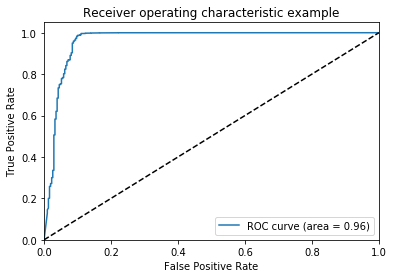

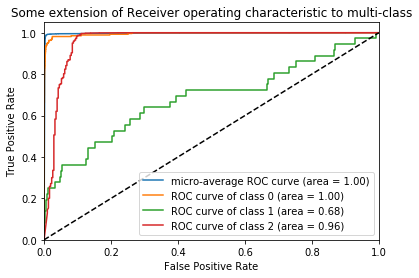

In [13]:
#code from https://scikit-learn.org/0.15/auto_examples/plot_roc.html
#from itertools import cycle

y_score = best_mlp.predict_proba(X_validation)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_validation[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_validation.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print(Y_validation.ravel())
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="best")
plt.show()